<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/ParEGO_EI_5d_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.stats import norm




In [43]:

# --- Define 5D objective functions ---
# Objectives for DTLZ2 5D Tests
def objective_f1(x):
    x = np.array(x)
    g = np.sum((x[2:] - 0.5)**2)  # g(x3, x4, x5)
    f1 = (1 + g) * np.cos(x[0] * np.pi / 2) * np.cos(x[1] * np.pi / 2)
    return f1

def objective_f2(x):
    x = np.array(x)
    g = np.sum((x[2:] - 0.5)**2)  # g(x3, x4, x5)
    f2 = (1 + g) * np.cos(x[0] * np.pi / 2) * np.sin(x[1] * np.pi / 2)
    return f2



# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(x, surrogate_f1, surrogate_f2, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    f1_pred = surrogate_f1.predict([x])[0]
    f2_pred = surrogate_f2.predict([x])[0]

    # Tchebycheff scalarization
    scalar_value = max(weights[0] * f1_pred, weights[1] * f2_pred)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_pred + weights[1] * f2_pred)

    return -scalar_value

# --- AQ func: Expected Improvement ---
def expected_improvement(x, surrogate_f1, surrogate_f2, weights, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.
    """
    x = np.array(x).reshape(1, -1)

    mu_f1, sigma_f1 = surrogate_f1.predict(x, return_std=True)
    mu_f2, sigma_f2 = surrogate_f2.predict(x, return_std=True)

    mu_scalar = np.maximum(weights[0] * mu_f1, weights[1] * mu_f2)
    phi = 0.05
    mu_scalar += phi * (weights[0] * mu_f1 + weights[1] * mu_f2)

    # Approximate variance of scalarized objective
    sigma_scalar = np.sqrt(weights[0]**2 * sigma_f1**2 + weights[1]**2 * sigma_f2**2)

    # Compute EI
    with np.errstate(divide='warn'):
        Z = (y_best - mu_scalar) / sigma_scalar
        ei = (y_best - mu_scalar) * norm.cdf(Z) + sigma_scalar * norm.pdf(Z)
        ei[sigma_scalar == 0.0] = 0.0

    return -ei[0]  # Negative for minimization


# --- Initialize random population ---
def initialize_population(pop_size, bounds):
    """
    outputs a matrix of mxn, where:
    m => number of (random) samples
    n => sampled values of the nth variable, we have 2 vars here so; mx2.

    This is where we would place a latin hypercube routine
    to select initial points

    Note that each row, correspondes to 1 scalar point for each objective


    """
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] >= f1_vals[i] and f2_vals[j] >= f2_vals[i]) and (f1_vals[j] > f1_vals[i] or f2_vals[j] > f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)


# --- ParEGO Main Loop ---
def par_ego(num_generations, pop_size, bounds):
    population = initialize_population(pop_size, bounds)

    f1_vals = np.array([objective_f1(p) for p in population])
    f2_vals = np.array([objective_f2(p) for p in population])
    # Note that: objective_f1(p) for p in population loops through each row
    # Each row is a sample. If we have m rows, the length of f1_vals and
    # f2_vals, is m.

    # Initialize where we will store solutions
    pareto_all = []

    for gen in range(num_generations):
        # generation = iteration

        # Train surrogate models
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces
        surrogate_f1 = surrogate_model(population, f1_vals)
        surrogate_f2 = surrogate_model(population, f2_vals)
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        # Scalarized function value of current best point
        phi = 0.05
        f1_preds = surrogate_f1.predict(population)
        f2_preds = surrogate_f2.predict(population)
        scalar_preds = np.maximum(weights[0] * f1_preds, weights[1] * f2_preds)
        scalar_preds += phi * (weights[0] * f1_preds + weights[1] * f2_preds)
        y_best = np.max(scalar_preds)

        # Optimize EI instead of Tchebycheff directly
        result = differential_evolution(
            expected_improvement,
            bounds=bounds,
            args=(surrogate_f1, surrogate_f2, weights, y_best),
            maxiter=20,
            popsize=10,
            seed=42,
            disp=False
        )

        x_new = result.x
        f1_new = objective_f1(x_new)
        f2_new = objective_f2(x_new)

        # Add to population
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f"Gen {gen+1} | New f1: {f1_new}, f2: {f2_new}")

    return pareto_all[-1], f1_vals, f2_vals



In [64]:
# --- Run ParEGO ---
bounds = np.array([
    [0, 1],  # x1
    [0, 1],  # x2
    [0, 1],  # x3
    [0, 1],  # x4
    [0, 1],  # x5
])
num_generations = 5 # iterations
pop_size = 20     # number of initial samples to draw and train the GPs on.

pareto_front, all_f1, all_f2 = par_ego(num_generations, pop_size, bounds)



Gen 1 | New f1: 0.3041, f2: 0.3349
Gen 2 | New f1: 0.0000, f2: 0.0000
Gen 3 | New f1: 0.0000, f2: 0.0000
Gen 4 | New f1: 0.0000, f2: 0.0000
Gen 5 | New f1: 0.0000, f2: 0.0000


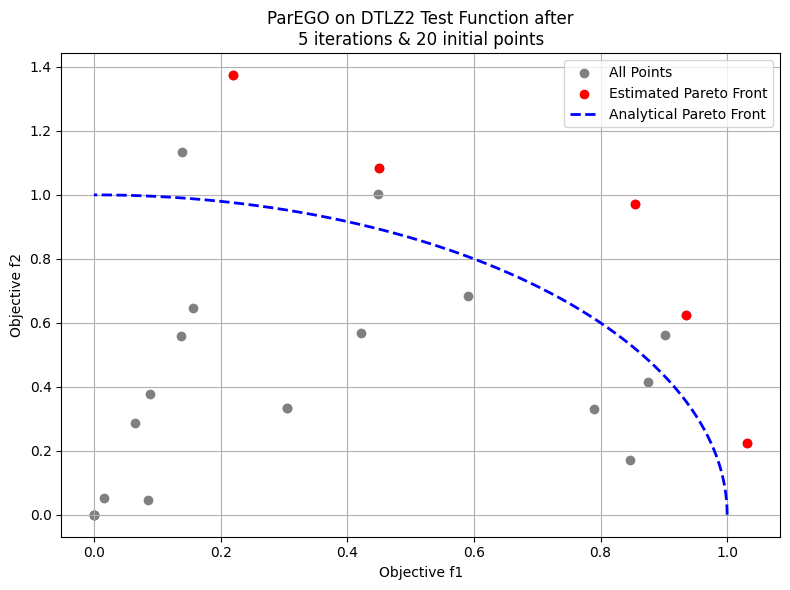

In [66]:
# --- Plot Results ---


# Generate analytical Pareto front for DTLZ2 (quarter circle from (1,0) to (0,1))
x0_vals = np.linspace(0, 1, 200)
pareto_f1_analytical = np.cos(0.5 * np.pi * x0_vals)
pareto_f2_analytical = np.sin(0.5 * np.pi * x0_vals)

plt.figure(figsize=(8, 6))

# Plot evaluated points and estimated Pareto front from your model
plt.scatter(all_f1, all_f2, c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Estimated Pareto Front")

# Plot analytical Pareto front curve
plt.plot(pareto_f1_analytical, pareto_f2_analytical, 'b--', linewidth=2, label="Analytical Pareto Front")

# Plot labels and styling
plt.xlabel("Objective f1")
plt.ylabel("Objective f2")
plt.title(f"ParEGO on DTLZ2 Test Function after\n{num_generations} iterations & {pop_size} initial points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
